# Propellant Storage

In [4]:
using PyPlot
using PorousMaterials
PyPlot.matplotlib.style.use("Solarize_Light2")
PorousMaterials.PATH_TO_DATA
set_tutorial_mode()
PorousMaterials.PATH_TO_DATA

┌ Warning: Directory for input data, "data", not found in present working directory, C:\Users\Owner\Box\GitHub\PropellantStorage
│ Change the PATH_TO_DATA variable to load input files from a different directory. See "set_path_to_data()".
└ @ PorousMaterials C:\Users\Owner\.julia\environments\v1.1\dev\PorousMaterials\src\PorousMaterials.jl:27
┌ Warning: PorousMaterials is now in Tutorial Mode. You have access to the testing data to experiment with PorousMaterials.
│ To get access to your own data use: reset_path_to_data()
└ @ PorousMaterials C:\Users\Owner\.julia\environments\v1.1\dev\PorousMaterials\src\PorousMaterials.jl:75


"C:\\Users\\Owner\\.julia\\environments\\v1.1\\dev\\PorousMaterials\\src\\..\\test\\data"

The temperature is 300 K in the atmosphere.

In [5]:
T = 300.0 # K

300.0

Universal gas constant

In [6]:
const R = 8.3144598e-5 # m³-bar/(K-mol)

8.3144598e-5

Mass desired of propellant

In [7]:
m_p = 1000 # mol

1000

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = VdWFluid(::Symbol) at EOS.jl:151
└ @ PorousMaterials C:\Users\Owner\.julia\environments\v1.1\dev\PorousMaterials\src\EOS.jl:151


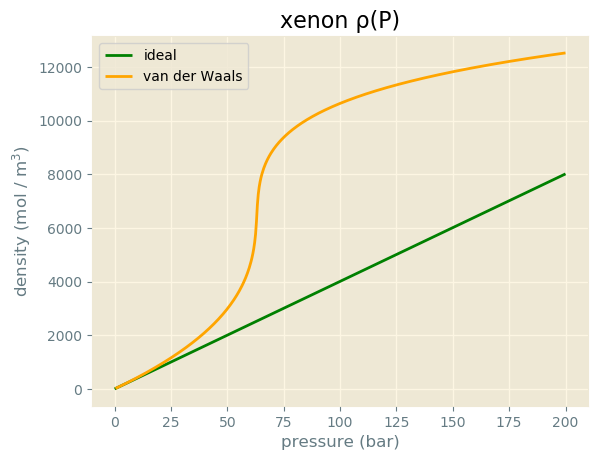

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = VdWFluid(::Symbol) at EOS.jl:154
└ @ PorousMaterials C:\Users\Owner\.julia\environments\v1.1\dev\PorousMaterials\src\EOS.jl:154
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = VdWFluid(::Symbol) at EOS.jl:155
└ @ PorousMaterials C:\Users\Owner\.julia\environments\v1.1\dev\PorousMaterials\src\EOS.jl:155


In [8]:
P = range(0.0, stop=200.0, length=500) # bar

# ideal gas density
ρ_ig = P / (R * T) # mol / m³

ρ_vdw = zeros(length(P))
xe = VdWFluid(:Xe)

for (i, p_i) in enumerate(P)
    props = calculate_properties(xe, T, p_i, verbose=false)
    ρ_vdw[i] = props["density (mol/m³)"]
end
    
figure()
plot(P, ρ_ig, color="green", label="ideal")
plot(P, ρ_vdw, color="orange", label="van der Waals")
xlabel("pressure (bar)")
ylabel("density (mol / m\$^3\$)")
legend()
title("xenon ρ(P)")
savefig("Xenon Ideal Gas vs. van der Waals Gas Density.png", format="png",
       dpi=300)

In [9]:
collect(P)

500-element Array{Float64,1}:
   0.0                
   0.40080160320641284
   0.8016032064128257 
   1.2024048096192386 
   1.6032064128256514 
   2.004008016032064  
   2.404809619238477  
   2.80561122244489   
   3.2064128256513027 
   3.6072144288577155 
   4.008016032064128  
   4.408817635270541  
   4.809619238476954  
   ⋮                  
 195.59118236472946   
 195.99198396793588   
 196.3927855711423    
 196.7935871743487    
 197.1943887775551    
 197.59519038076152   
 197.99599198396794   
 198.39679358717436   
 198.79759519038078   
 199.19839679358716   
 199.59919839679358   
 200.0                

For a thin-walled containing a supercritical, pressurized fluid without considering safety factor \beta

In [10]:
ρ_tank = 4506 # titanium density (kg/m³)
σ = 4340 # yield strength of titanium (bar)

4340

In [20]:
xe = VdWFluid(:Xe)
r = ((m_p * 3) ./ ((4 * π) .* ρ_vdw)) .^ (1/3) # inner radius of tank (m)

500-element Array{Float64,1}:
 NaN                  
   2.4567866749227627 
   1.9486973827572718 
   1.701242281415604  
   1.5446757369135495 
   1.433012318630718  
   1.3476298708997074 
   1.2792869984122288 
   1.222781258904587  
   1.1749187510615053 
   1.1336100494863337 
   1.0974200832635979 
   1.065324476225853  
   ⋮                  
   0.2674670549338611 
   0.26743267575155183
   0.26739840286570243
   0.26736423565345935
   0.26733017349742194
   0.26729621578557783
   0.267262361911241  
   0.26722861127298947
   0.267194963274605  
   0.2671614173250121 
   0.2671279728382204 
   0.2670946292332644 

In [25]:
V = 1 ./ ρ_vdw # m^3 / mol
l = (4 / 3 .* r) - V ./ (π * r .^2) #length of cylindrical side --CHECK THIS

500-element Array{Float64,1}:
 NaN                  
   3.2724398509971198 
   2.5956649138326857 
   2.2660547188455844 
   2.057508081568848  
   1.9087724084161162 
   1.7950429880384102 
   1.7040102818850886 
   1.62874463686091   
   1.5649917764139252 
   1.5099685859157965 
   1.4617635509071123 
   1.419012202332836  
   ⋮                  
   0.35626611717190293
   0.356220324101067  
   0.3561746726171156 
   0.35612916189040783
   0.35608379109856597
   0.3560385594263896 
   0.3559934660657729 
   0.35594851021562196
   0.35590369108177383
   0.35585900787691604
   0.3558144598205095 
   0.35577004613870816

Minimum wall thickness required to contain the pressure of supercritical fluid. Tensile stress occurs from `S = P * r / (2 * t)` and `S = sigma / beta` where sigma is yield strength of the material and beta is the safety factor. In this plot, we will not decide sigma and beta yet. 

In [26]:
t_sphere = P .* r / (2 * σ) # spherical/endcaps thickness (m)
t_cyl = P .* r / σ # cylinderical thickness (m)

500-element Array{Float64,1}:
 NaN                     
   0.00022688572305188838
   0.0003599267443194725 
   0.0004713322353690619 
   0.0005706069233078321 
   0.0006616977358545284 
   0.0007467265614545446 
   0.0008270004514915177 
   0.0009033966616400263 
   0.0009765400625724766 
   0.0010468956802880726 
   0.001114821432348529  
   0.0011806002525521304 
   ⋮                     
   0.012053962561780169  
   0.012077110760000079  
   0.012100257418449268  
   0.0121234025383346    
   0.012146546120880617  
   0.012169688167329116  
   0.012192828678938804  
   0.012215967656984917  
   0.012239105102758892  
   0.012262241017567947  
   0.012285375402734847  
   0.012308508259597437  

The mass of the tank can be found using the inner radius, the density of the tank material, and the thickness of the wall.

In [33]:
m_tank_spherical = (4 * ρ_tank * π) .* r .^2 .* t_sphere # kg
m_tank_cylindrical = ρ_tank * 2 * π .* r .* (2 .* r .* t_sphere .+ l .* t_cyl)

500-element Array{Float64,1}:
 NaN                
  90.41524555699868 
  90.24071415765388 
  90.06562778054568 
  89.88998094614793 
  89.71376808394203 
  89.5369835302897  
  89.35962152623948 
  89.1816762152677  
  89.00314164094954 
  88.82401174455828 
  88.64428036259032 
  88.46394122421201 
   ⋮                
  56.93378166739379 
  57.028452947069404
  57.12310805137331 
  57.21774697896879 
  57.31236972891991 
  57.40697630068354 
  57.50156669410275 
  57.59614090939947 
  57.69069894716799 
  57.78524080836739 
  57.87976649431622 
  57.974276006684406

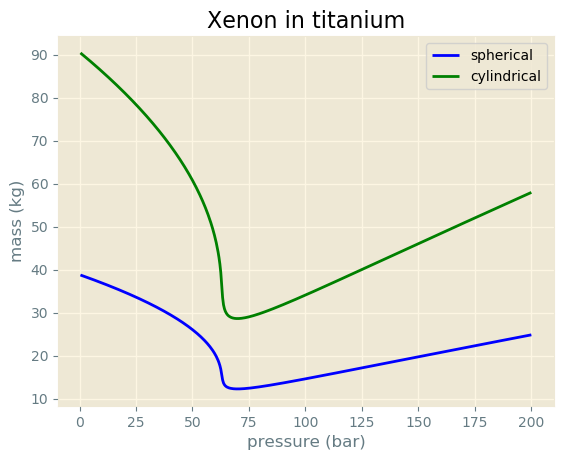

In [34]:
figure()
plot(P, m_tank_spherical, color="blue", label="spherical")
plot(P, m_tank_cylindrical, color="green", label="cylindrical")
xlabel("pressure (bar)")
ylabel("mass (kg)")
legend()
title("Xenon in titanium")
savefig("Xenon van der Waals Gas in Titanium.png", format="png",
       dpi=300)

Sphere is preferred for storage of high pressure fluids. Theoretically, a sphere would be the best shape of a pressure vessel. However, a spherical shape is tough to manufacture, therefore more expensive, so most pressure vessels are cylindrical with 2:1 semi-elliptical heads or end caps on each end. The drawback to cylindrical types is cylinders are not as strong as spheres due to the weak point at each end.

NOTE: this is using PURE titanium. Titanium is typically used only as an inner lining with carbon fiber overwrapping* 